In [11]:
import os
import pandas as pd
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
import gensim
from gensim import corpora, models, similarities
import logging
import tempfile
from nltk.corpus import stopwords
from string import punctuation
from collections import OrderedDict
import seaborn as sns
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

init_notebook_mode(connected=True) #do not miss this line

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# You might need to do this only once.
import nltk
nltk.download('stopwords')

In [12]:
datafile = 'data/tcat_TestingRelations-20200323-20200618-fullExport.csv'

In [13]:
import pandas as pd
tweets = pd.read_csv(datafile, encoding='latin1')
tweets = tweets.assign(created_at=pd.to_datetime(tweets.created_at))

print("Number of tweets: ",len(tweets['text']))
tweets.head(5)

Number of tweets:  132412


ï»¿id                    created_at   from_user_name  \
0  1242049982619889664 1970-01-01 00:00:01.584962766  AlmostSenseless   
1  1242049999401345024 1970-01-01 00:00:01.584962770          XantahR   
2  1242050532623212546 1970-01-01 00:00:01.584962897        lettyruta   
3  1242053661309784067 1970-01-01 00:00:01.584963643          no__ddy   
4  1242054190098235393 1970-01-01 00:00:01.584963769       emimatsgal   

                                                text lang  \
0  RT @GaryBurgessCI: Guernsey coronavirus press ...   en   
1  RT @balleralert: Idris Elbaâs Wife Sabrina D...   en   
2  RT @PopCrave: Idris Elbaâs wife Sabrina test...   en   
3  RT @spectatorindex: JUST IN: State prison inma...   en   
4  RT @PopCrave: Idris Elbaâs wife Sabrina test...   en   

                      location  lat  lng         from_user_id  \
0  Sark, Bailiwick of Guernsey  NaN  NaN            130773785   
1          catch me if you can  NaN  NaN  1006648588791943168   
2                          NaN  NaN  NaN           1690940252   
3                          NaN  NaN  NaN            290487664   
4                      Nigeria  NaN  NaN           1048192736   

  from_user_realname  from_user_tweetcount  from_user_followercount  \
0    Victoria Stamps                 87821                     1196   
1         Xantah????                 17738                      925   
2              Letty                  2737                      160   
3         Nodthegang                  3429                      115   
4        Matsgal_Jnr                 11733                     1332   

   from_user_friendcount  from_user_favourites_count  
0                    962                       13590  
1                    983                       45897  
2                    121                         189  
3                   1010                        9943  
4                   2398                       23370

In [10]:
'''import plotly.plotly as py
import plotly.graph_objs as go
'''
tweets['created_at'] = pd.to_datetime(tweets['created_at'], format='%y-%m-%d %H:%M:%S')
tweetsT = tweets['created_at']

trace = go.Histogram(
    x=tweetsT,
    marker=dict(
        color='blue'
    ),
    opacity=0.75
)

layout = go.Layout(
    title='Tweet Activity Over Years',
    height=450,
    width=1200,
    xaxis=dict(
        title='Month and year'
    ),
    yaxis=dict(
        title='Tweet Quantity'
    ),
    bargap=0.2,
)

data = [trace]

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [14]:
# Preparing a corpus for analysis and checking first 10 entries

corpus=[]
a=[]
for i in range(len(tweets['text'])):
        a=tweets['text'][i]
        corpus.append(a)
        
corpus[0:10]

['RT @GaryBurgessCI: Guernsey coronavirus press conference now underway. Highlights as we go...  â\x80¢â\x80\x9dCommunity is anxious and fearful and thatâ\x80\x99s understandableâ\x80\x9d says Chief Minister â\x80¢Rise in positive tests (20) should be seen as good news as all are from off-island travel and not community spread',
 'RT @balleralert: Idris Elbaâ\x80\x99s Wife Sabrina Dhowre-Elba Tests Positive For Coronavirus: â\x80\x9cI Wanted To Be With Himâ\x80\x9d https://t.co/HW82WqrtQs https://t.co/YRwn2XHI19',
 'RT @PopCrave: Idris Elbaâ\x80\x99s wife Sabrina tests positive for Coronavirus days after actorâ\x80\x99s positive diagnosis, explains why she didnâ\x80\x99t distance herself:  â\x80\x9cI wanted to be with him. Thatâ\x80\x99s the instinct of a wife. You want to go and take care.â\x80\x9d https://t.co/1pN4ZoGed2',
 'RT @spectatorindex: JUST IN: State prison inmate in Los Angeles County tests positive for coronavirus',
 'RT @PopCrave: Idris Elbaâ\x80\x99s wife Sabrina tests p

In [15]:
TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Folder "/var/folders/sl/wxrn89b1285_h_36lggkfydw0000gn/T" will be used to save temporary dictionary and corpus.


In [19]:
# removing common words and tokenizing
list1 = ['RT','rt']
stoplist = stopwords.words('english') + list(punctuation) + list1

texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in corpus]

dictionary = corpora.Dictionary(texts)
dictionary.save(os.path.join(TEMP_FOLDER, 'elon.dict'))  # store the dictionary, for future reference

#print(dictionary)
#print(dictionary.token2id)

2020-06-20 16:48:09,299 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-06-20 16:48:09,607 : INFO : adding document #10000 to Dictionary(11314 unique tokens: ['(20)', '@garyburgessci:', 'anxious', 'chief', 'community']...)
2020-06-20 16:48:09,940 : INFO : adding document #20000 to Dictionary(17234 unique tokens: ['(20)', '@garyburgessci:', 'anxious', 'chief', 'community']...)
2020-06-20 16:48:10,286 : INFO : adding document #30000 to Dictionary(22496 unique tokens: ['(20)', '@garyburgessci:', 'anxious', 'chief', 'community']...)
2020-06-20 16:48:10,617 : INFO : adding document #40000 to Dictionary(27813 unique tokens: ['(20)', '@garyburgessci:', 'anxious', 'chief', 'community']...)
2020-06-20 16:48:10,911 : INFO : adding document #50000 to Dictionary(34465 unique tokens: ['(20)', '@garyburgessci:', 'anxious', 'chief', 'community']...)
2020-06-20 16:48:11,357 : INFO : adding document #60000 to Dictionary(35079 unique tokens: ['(20)', '@garyburgessci:', 'anxious', 'ch

In [20]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize(os.path.join(TEMP_FOLDER, 'elon.mm'), corpus)  # store to disk, for later use


2020-06-20 16:49:34,803 : INFO : storing corpus in Matrix Market format to /var/folders/sl/wxrn89b1285_h_36lggkfydw0000gn/T/elon.mm
2020-06-20 16:49:34,805 : INFO : saving sparse matrix to /var/folders/sl/wxrn89b1285_h_36lggkfydw0000gn/T/elon.mm
2020-06-20 16:49:34,805 : INFO : PROGRESS: saving document #0
2020-06-20 16:49:34,830 : INFO : PROGRESS: saving document #1000
2020-06-20 16:49:34,853 : INFO : PROGRESS: saving document #2000
2020-06-20 16:49:34,876 : INFO : PROGRESS: saving document #3000
2020-06-20 16:49:34,901 : INFO : PROGRESS: saving document #4000
2020-06-20 16:49:34,925 : INFO : PROGRESS: saving document #5000
2020-06-20 16:49:34,950 : INFO : PROGRESS: saving document #6000
2020-06-20 16:49:34,978 : INFO : PROGRESS: saving document #7000
2020-06-20 16:49:35,005 : INFO : PROGRESS: saving document #8000
2020-06-20 16:49:35,032 : INFO : PROGRESS: saving document #9000
2020-06-20 16:49:35,056 : INFO : PROGRESS: saving document #10000
2020-06-20 16:49:35,082 : INFO : PROGRESS

2020-06-20 16:49:38,211 : INFO : PROGRESS: saving document #121000
2020-06-20 16:49:38,232 : INFO : PROGRESS: saving document #122000
2020-06-20 16:49:38,254 : INFO : PROGRESS: saving document #123000
2020-06-20 16:49:38,281 : INFO : PROGRESS: saving document #124000
2020-06-20 16:49:38,306 : INFO : PROGRESS: saving document #125000
2020-06-20 16:49:38,327 : INFO : PROGRESS: saving document #126000
2020-06-20 16:49:38,346 : INFO : PROGRESS: saving document #127000
2020-06-20 16:49:38,368 : INFO : PROGRESS: saving document #128000
2020-06-20 16:49:38,391 : INFO : PROGRESS: saving document #129000
2020-06-20 16:49:38,420 : INFO : PROGRESS: saving document #130000
2020-06-20 16:49:38,445 : INFO : PROGRESS: saving document #131000
2020-06-20 16:49:38,475 : INFO : PROGRESS: saving document #132000
2020-06-20 16:49:38,490 : INFO : saved 132412x67928 matrix, density=0.033% (2988491/8994482336)
2020-06-20 16:49:38,491 : INFO : saving MmCorpus index to /var/folders/sl/wxrn89b1285_h_36lggkfydw00

In [21]:
tfidf = models.TfidfModel(corpus) # step 1 -- initialize a model

2020-06-20 16:50:04,905 : INFO : collecting document frequencies
2020-06-20 16:50:04,905 : INFO : PROGRESS: processing document #0
2020-06-20 16:50:04,940 : INFO : PROGRESS: processing document #10000
2020-06-20 16:50:04,976 : INFO : PROGRESS: processing document #20000
2020-06-20 16:50:05,013 : INFO : PROGRESS: processing document #30000
2020-06-20 16:50:05,049 : INFO : PROGRESS: processing document #40000
2020-06-20 16:50:05,082 : INFO : PROGRESS: processing document #50000
2020-06-20 16:50:05,130 : INFO : PROGRESS: processing document #60000
2020-06-20 16:50:05,169 : INFO : PROGRESS: processing document #70000
2020-06-20 16:50:05,200 : INFO : PROGRESS: processing document #80000
2020-06-20 16:50:05,231 : INFO : PROGRESS: processing document #90000
2020-06-20 16:50:05,270 : INFO : PROGRESS: processing document #100000
2020-06-20 16:50:05,305 : INFO : PROGRESS: processing document #110000
2020-06-20 16:50:05,339 : INFO : PROGRESS: processing document #120000
2020-06-20 16:50:05,371 : 

In [22]:
corpus_tfidf = tfidf[corpus]  # step 2 -- use the model to transform vectors

In [23]:
total_topics = 5

In [24]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold

2020-06-20 16:50:57,444 : INFO : using symmetric alpha at 0.2
2020-06-20 16:50:57,445 : INFO : using symmetric eta at 0.2
2020-06-20 16:50:57,455 : INFO : using serial LDA version on this node
2020-06-20 16:50:57,483 : INFO : running online (single-pass) LDA training, 5 topics, 1 passes over the supplied corpus of 132412 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2020-06-20 16:50:57,484 : INFO : PROGRESS: pass 0, at document #2000/132412
2020-06-20 16:50:58,552 : INFO : merging changes from 2000 documents into a model of 132412 documents
2020-06-20 16:50:58,582 : INFO : topic #0 (0.200): 0.033*"testing" + 0.028*"community" + 0.025*"cases" + 0.024*"#coronavirus" + 0.023*"well" + 0.023*"done" + 0.023*"@cmoireland" + 0.022*"@gabrielscally:" + 0.022*"showing" + 0.022*"contacts"
2020-06-20 16:50:58,583 : INFO : topic #1 (0.200): 0.038*"husband" + 0.035*"test" + 0.034*"says" + 0.033*

2020-06-20 16:51:01,231 : INFO : topic #3 (0.200): 0.061*"tests" + 0.035*"coronavirus" + 0.035*"positive" + 0.030*"millions" + 0.029*"test" + 0.029*"angeles" + 0.029*"los" + 0.029*"scarce" + 0.026*"arizona" + 0.022*"rep."
2020-06-20 16:51:01,233 : INFO : topic #4 (0.200): 0.048*"coronavirus" + 0.043*"state" + 0.035*"said" + 0.028*"stanton" + 0.027*"test" + 0.026*"officials" + 0.020*"testing" + 0.018*"crisis" + 0.018*"positive" + 0.018*"could"
2020-06-20 16:51:01,234 : INFO : topic diff=0.453831, rho=0.408248
2020-06-20 16:51:01,235 : INFO : PROGRESS: pass 0, at document #14000/132412
2020-06-20 16:51:01,713 : INFO : merging changes from 2000 documents into a model of 132412 documents
2020-06-20 16:51:01,725 : INFO : topic #0 (0.200): 0.063*"currently" + 0.063*"time," + 0.061*"hearing" + 0.042*"#coronavirus" + 0.038*"tested" + 0.030*"scientists" + 0.020*"kaduna" + 0.015*"testing" + 0.015*"tests" + 0.014*"key"
2020-06-20 16:51:01,726 : INFO : topic #1 (0.200): 0.045*"test" + 0.042*"coron

2020-06-20 16:51:04,779 : INFO : topic #2 (0.200): 0.040*"coronavirus" + 0.038*"tests" + 0.033*"trumpâs" + 0.033*"donald" + 0.032*"take" + 0.032*"iâm" + 0.030*"agree" + 0.030*"pain" + 0.028*"president" + 0.027*"announced"
2020-06-20 16:51:04,780 : INFO : topic #3 (0.200): 0.060*"call" + 0.056*"pres." + 0.041*"@cbsnews:" + 0.040*"monday" + 0.033*"tests" + 0.027*"state" + 0.025*"equipment," + 0.023*"rural" + 0.022*"coronavirus" + 0.021*"positive"
2020-06-20 16:51:04,782 : INFO : topic #4 (0.200): 0.092*"trump" + 0.050*"testing" + 0.049*"state" + 0.047*"news" + 0.033*"steve" + 0.033*"gov." + 0.031*"governor" + 0.029*"pritzker" + 0.027*"coronavirus" + 0.024*"bullock"
2020-06-20 16:51:04,784 : INFO : topic diff=0.293881, rho=0.288675
2020-06-20 16:51:04,785 : INFO : PROGRESS: pass 0, at document #26000/132412
2020-06-20 16:51:05,226 : INFO : merging changes from 2000 documents into a model of 132412 documents
2020-06-20 16:51:05,241 : INFO : topic #0 (0.200): 0.039*"processed" + 0.032*"

2020-06-20 16:51:07,340 : INFO : topic #2 (0.200): 0.045*"coronavirus" + 0.038*"donald" + 0.032*"earlier" + 0.027*"announced" + 0.027*"iâm" + 0.025*"pain" + 0.024*"get" + 0.021*"tests" + 0.019*"plan" + 0.019*"wants"
2020-06-20 16:51:07,342 : INFO : topic #3 (0.200): 0.058*"govt" + 0.050*"random" + 0.050*"delhi" + 0.030*"first" + 0.030*"state" + 0.029*"coronavirus" + 0.025*"1" + 0.025*"test" + 0.024*"seen" + 0.024*"tests"
2020-06-20 16:51:07,343 : INFO : topic #4 (0.200): 0.056*"testing" + 0.042*"coronavirus" + 0.038*"state" + 0.034*"breaking:" + 0.033*"areas" + 0.032*"next" + 0.032*"big" + 0.028*"trump" + 0.026*"begin" + 0.020*"test"
2020-06-20 16:51:07,344 : INFO : topic diff=0.219020, rho=0.235702
2020-06-20 16:51:07,345 : INFO : PROGRESS: pass 0, at document #38000/132412
2020-06-20 16:51:07,806 : INFO : merging changes from 2000 documents into a model of 132412 documents
2020-06-20 16:51:07,821 : INFO : topic #0 (0.200): 0.048*"well" + 0.043*"done" + 0.041*"start" + 0.040*"testin

2020-06-20 16:51:10,424 : INFO : topic #2 (0.200): 0.051*"support" + 0.047*"coronavirus" + 0.027*"hydroxychloroquine" + 0.026*"let" + 0.021*"earlier" + 0.019*"announced" + 0.016*"donald" + 0.013*"get" + 0.010*"body" + 0.009*"tests"
2020-06-20 16:51:10,426 : INFO : topic #3 (0.200): 0.045*"test" + 0.035*"state" + 0.034*"coronavirus" + 0.026*"positive" + 0.022*"first" + 0.019*"govt" + 0.019*"tests" + 0.017*"delhi" + 0.016*"random" + 0.015*"#coronavirus"
2020-06-20 16:51:10,428 : INFO : topic #4 (0.200): 0.055*"coronavirus" + 0.053*"testing" + 0.034*"trump" + 0.028*"state" + 0.023*"across" + 0.021*"test" + 0.020*"federal" + 0.017*"nation" + 0.015*"states" + 0.015*"administration"
2020-06-20 16:51:10,428 : INFO : topic diff=0.164063, rho=0.204124
2020-06-20 16:51:10,429 : INFO : PROGRESS: pass 0, at document #50000/132412
2020-06-20 16:51:10,817 : INFO : merging changes from 2000 documents into a model of 132412 documents
2020-06-20 16:51:10,829 : INFO : topic #0 (0.200): 0.039*"coronaviru

2020-06-20 16:51:13,292 : INFO : topic #2 (0.200): 0.039*"coronavirus" + 0.033*"support" + 0.020*"let" + 0.017*"hydroxychloroquine" + 0.016*"force" + 0.015*"task" + 0.015*"get" + 0.014*"earlier" + 0.012*"announced" + 0.011*"donald"
2020-06-20 16:51:13,294 : INFO : topic #3 (0.200): 0.050*"past" + 0.050*"counts" + 0.050*"stay-at-home" + 0.050*"order" + 0.049*"week." + 0.048*"prison." + 0.047*"cases" + 0.045*"beginning." + 0.044*"due" + 0.043*"state"
2020-06-20 16:51:13,295 : INFO : topic #4 (0.200): 0.143*"trump" + 0.134*"lack" + 0.066*"testing" + 0.051*"breaking:" + 0.048*"coronavirus" + 0.043*"low." + 0.030*"state" + 0.019*"liar" + 0.014*"due" + 0.010*"increase"
2020-06-20 16:51:13,296 : INFO : topic diff=0.107839, rho=0.182574
2020-06-20 16:51:13,297 : INFO : PROGRESS: pass 0, at document #62000/132412
2020-06-20 16:51:13,627 : INFO : merging changes from 2000 documents into a model of 132412 documents
2020-06-20 16:51:13,638 : INFO : topic #0 (0.200): 0.069*"belongs" + 0.068*"pandem

2020-06-20 16:51:15,693 : INFO : topic #3 (0.200): 0.047*"state" + 0.042*"week." + 0.041*"cases" + 0.041*"past" + 0.041*"counts" + 0.041*"stay-at-home" + 0.040*"order" + 0.039*"prison." + 0.038*"due" + 0.037*"beginning."
2020-06-20 16:51:15,694 : INFO : topic #4 (0.200): 0.070*"trump" + 0.060*"lack" + 0.056*"coronavirus" + 0.052*"testing" + 0.039*"state" + 0.028*"kits" + 0.022*"test" + 0.020*"health" + 0.018*"breaking:" + 0.016*"local"
2020-06-20 16:51:15,695 : INFO : topic diff=0.140395, rho=0.166667
2020-06-20 16:51:15,696 : INFO : PROGRESS: pass 0, at document #74000/132412
2020-06-20 16:51:16,078 : INFO : merging changes from 2000 documents into a model of 132412 documents
2020-06-20 16:51:16,089 : INFO : topic #0 (0.200): 0.060*"belongs" + 0.060*"pandemic" + 0.053*"ok." + 0.050*"sd," + 0.046*"ne," + 0.043*"74%" + 0.043*"82%" + 0.043*"60%" + 0.043*"205%" + 0.043*"53%"
2020-06-20 16:51:16,091 : INFO : topic #1 (0.200): 0.039*"state" + 0.037*"coronavirus" + 0.035*"testing" + 0.024*"d

2020-06-20 16:51:18,561 : INFO : topic #4 (0.200): 0.059*"testing" + 0.047*"state" + 0.046*"coronavirus" + 0.035*"trump" + 0.026*"health" + 0.024*"test" + 0.021*"lack" + 0.021*"allegedly" + 0.017*"coronavirus:" + 0.014*"us"
2020-06-20 16:51:18,562 : INFO : topic diff=0.105172, rho=0.154303
2020-06-20 16:51:18,563 : INFO : PROGRESS: pass 0, at document #86000/132412
2020-06-20 16:51:18,907 : INFO : merging changes from 2000 documents into a model of 132412 documents
2020-06-20 16:51:18,919 : INFO : topic #0 (0.200): 0.039*"pandemic" + 0.037*"coronavirus" + 0.037*"without" + 0.037*"four" + 0.037*"belongs" + 0.036*"prisons," + 0.036*"nearly" + 0.032*"ok." + 0.030*"sd," + 0.030*"60%"
2020-06-20 16:51:18,920 : INFO : topic #1 (0.200): 0.071*"positive" + 0.045*"state" + 0.044*"new" + 0.037*"u.s." + 0.034*"york" + 0.033*"3,300" + 0.032*"coronavirus" + 0.029*"testing" + 0.023*"test" + 0.019*"@nbcnews:"
2020-06-20 16:51:18,922 : INFO : topic #2 (0.200): 0.069*"nigerian" + 0.048*"manipulate" + 0

2020-06-20 16:51:21,046 : INFO : topic #4 (0.200): 0.048*"coronavirus" + 0.046*"testing" + 0.045*"state" + 0.022*"maryland" + 0.022*"federal" + 0.017*"test" + 0.017*"nursing" + 0.016*"edo" + 0.015*"police" + 0.014*"national"
2020-06-20 16:51:21,047 : INFO : topic diff=0.136995, rho=0.144338
2020-06-20 16:51:21,048 : INFO : PROGRESS: pass 0, at document #98000/132412
2020-06-20 16:51:21,442 : INFO : merging changes from 2000 documents into a model of 132412 documents
2020-06-20 16:51:21,454 : INFO : topic #0 (0.200): 0.047*"coronavirus" + 0.027*"four" + 0.027*"prisons," + 0.026*"nearly" + 0.026*"without" + 0.026*"pandemic" + 0.025*"korea" + 0.022*"belongs" + 0.022*"effectively" + 0.021*"testing"
2020-06-20 16:51:21,456 : INFO : topic #1 (0.200): 0.069*"positive" + 0.033*"state" + 0.031*"coronavirus" + 0.030*"positive." + 0.029*"came" + 0.028*"lives" + 0.028*"away." + 0.026*"new" + 0.024*"her." + 0.019*"test"
2020-06-20 16:51:21,457 : INFO : topic #2 (0.200): 0.037*"tests" + 0.035*"pls" 

2020-06-20 16:51:24,170 : INFO : topic #4 (0.200): 0.051*"coronavirus" + 0.045*"testing" + 0.045*"state" + 0.036*"health" + 0.033*"@kylegriffin1:" + 0.033*"website" + 0.015*"test" + 0.013*"nursing" + 0.012*"federal" + 0.012*"maryland"
2020-06-20 16:51:24,171 : INFO : topic diff=0.140436, rho=0.136083
2020-06-20 16:51:24,172 : INFO : PROGRESS: pass 0, at document #110000/132412
2020-06-20 16:51:24,542 : INFO : merging changes from 2000 documents into a model of 132412 documents
2020-06-20 16:51:24,554 : INFO : topic #0 (0.200): 0.045*"coronavirus" + 0.032*"lockdowns" + 0.030*"world," + 0.027*"testing" + 0.021*"pandemic" + 0.016*"gives" + 0.016*"four" + 0.014*"sooner" + 0.014*"nearly" + 0.014*"prisons,"
2020-06-20 16:51:24,556 : INFO : topic #1 (0.200): 0.084*"positive" + 0.039*"data" + 0.038*"coronavirus" + 0.038*"department" + 0.037*"showed" + 0.031*"february," + 0.030*"state" + 0.023*"new" + 0.022*"lives" + 0.021*"test"
2020-06-20 16:51:24,557 : INFO : topic #2 (0.200): 0.049*"tests" 

2020-06-20 16:51:27,165 : INFO : topic #4 (0.200): 0.052*"testing" + 0.051*"coronavirus" + 0.042*"state" + 0.023*"health" + 0.014*"website" + 0.013*"@kylegriffin1:" + 0.013*"test" + 0.012*"nation" + 0.012*"tests" + 0.011*"program"
2020-06-20 16:51:27,166 : INFO : topic diff=0.122012, rho=0.129099
2020-06-20 16:51:27,166 : INFO : PROGRESS: pass 0, at document #122000/132412
2020-06-20 16:51:27,515 : INFO : merging changes from 2000 documents into a model of 132412 documents
2020-06-20 16:51:27,526 : INFO : topic #0 (0.200): 0.040*"coronavirus" + 0.035*"testing" + 0.021*"pandemic" + 0.018*"it," + 0.018*"lockdowns" + 0.017*"world," + 0.012*"aggressive" + 0.012*"--" + 0.010*"four" + 0.010*"nearly"
2020-06-20 16:51:27,528 : INFO : topic #1 (0.200): 0.070*"positive" + 0.041*"coronavirus" + 0.038*"new" + 0.028*"state" + 0.022*"data" + 0.022*"department" + 0.020*"test" + 0.020*"showed" + 0.019*"u.s." + 0.019*"tests"
2020-06-20 16:51:27,529 : INFO : topic #2 (0.200): 0.053*"tests" + 0.033*"coro

2020-06-20 16:51:29,203 : INFO : topic #4 (0.200): 0.070*"testing" + 0.051*"coronavirus" + 0.041*"state" + 0.019*"illinois" + 0.018*"firm" + 0.015*"health" + 0.013*"tests" + 0.011*"media" + 0.010*"test" + 0.009*"community"
2020-06-20 16:51:29,204 : INFO : topic diff=0.105948, rho=0.123091
2020-06-20 16:51:29,345 : INFO : -8.951 per-word bound, 495.0 perplexity estimate based on a held-out corpus of 412 documents with 9129 words
2020-06-20 16:51:29,345 : INFO : PROGRESS: pass 0, at document #132412/132412
2020-06-20 16:51:29,433 : INFO : merging changes from 412 documents into a model of 132412 documents
2020-06-20 16:51:29,444 : INFO : topic #0 (0.200): 0.046*"testing" + 0.041*"mum" + 0.031*"coronavirus" + 0.020*"story:" + 0.019*"state" + 0.017*"without" + 0.016*"done" + 0.015*"governor" + 0.014*"tribute" + 0.013*"sample"
2020-06-20 16:51:29,446 : INFO : topic #1 (0.200): 0.057*"new" + 0.054*"positive" + 0.038*"coronavirus" + 0.035*"state" + 0.023*"tests" + 0.022*""very" + 0.021*"york"

In [25]:
#Show first n important word in the topics:
lda.show_topics(total_topics,5)

[(0,
  '0.046*"testing" + 0.041*"mum" + 0.031*"coronavirus" + 0.020*"story:" + 0.019*"state"'),
 (1,
  '0.057*"new" + 0.054*"positive" + 0.038*"coronavirus" + 0.035*"state" + 0.023*"tests"'),
 (2,
  '0.038*"coronavirus" + 0.034*"family" + 0.031*"tests" + 0.023*"owns" + 0.023*"involved"'),
 (3,
  '0.040*"test" + 0.033*"positive" + 0.031*"coronavirus" + 0.027*"state" + 0.015*"cases"'),
 (4,
  '0.065*"testing" + 0.049*"coronavirus" + 0.039*"state" + 0.017*"illinois" + 0.016*"health"')]

In [26]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
#data_lda

In [27]:
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(5, 108)


2020-06-20 16:52:30,176 : INFO : Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-06-20 16:52:30,176 : INFO : NumExpr defaulting to 8 threads.


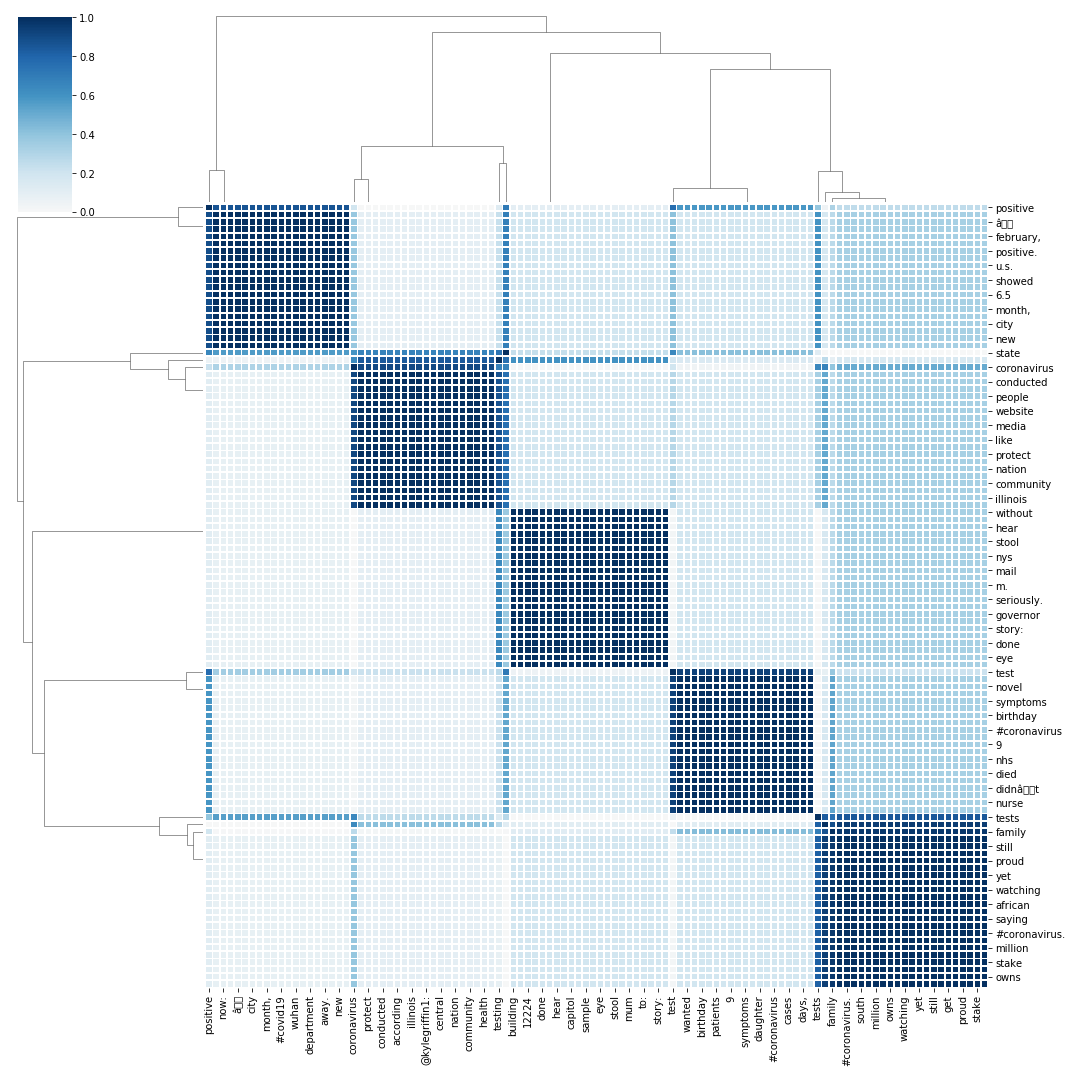

In [28]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(15, 15))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()
#plt.setp(ax_heatmap.get_yticklabels(), rotation=0)  # For y axis

In [29]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      150.222153  -72.269554       1        1  29.909363
3       51.163364 -159.968018       2        1  23.172308
2      -73.144554   21.523815       3        1  22.372829
0      -66.410133 -110.606438       4        1  12.296661
1       54.417324   12.443444       5        1  12.248830, topic_info=              Term         Freq        Total Category  logprob  loglift
15        positive  1918.000000  1918.000000  Default  30.0000  30.0000
94             new   938.000000   938.000000  Default  29.0000  29.0000
158        testing  4010.000000  4010.000000  Default  28.0000  28.0000
3324           mum   673.000000   673.000000  Default  27.0000  27.0000
320         family  1426.000000  1426.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
158        testing   202.469482  4010.480225   Topic5  -4.3835  -0.8863
711          cuomo   114.893890   177.930328   Topic5  -4.9500   1.6624
157        results   125.720703   302.661377   Topic5  -4.8600   1.2212
646       #covid19   125.999222   328.331085   Topic5  -4.8578   1.1420
86    #coronavirus   122.040543   668.115295   Topic5  -4.8897   0.3996

[348 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
1938       2  0.023451         "very
1938       3  0.215322         "very
1938       4  0.008528         "very
1938       5  0.754692         "very
86         1  0.254447  #coronavirus
...      ...       ...           ...
102        2  0.050212           â
102        5  0.870339           â
6418       3  1.000734           â¢
13259      1  0.997625        â¡ï¸
13259      4  0.006478        â¡ï¸

[545 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 3, 1, 2])

## Trying a second modelling run this time with 10 topics

In [30]:
total_topics = 10
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold
#Show first n important word in the topics:
lda.show_topics(total_topics,5)

2020-06-20 17:00:04,877 : INFO : using symmetric alpha at 0.1
2020-06-20 17:00:04,878 : INFO : using symmetric eta at 0.1
2020-06-20 17:00:04,887 : INFO : using serial LDA version on this node
2020-06-20 17:00:04,942 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 132412 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2020-06-20 17:00:04,945 : INFO : PROGRESS: pass 0, at document #2000/132412
2020-06-20 17:00:06,019 : INFO : merging changes from 2000 documents into a model of 132412 documents
2020-06-20 17:00:06,048 : INFO : topic #9 (0.100): 0.026*"testing" + 0.025*"cases" + 0.024*"community" + 0.024*"#coronavirus" + 0.023*"news" + 0.023*"done" + 0.022*"good" + 0.022*"showing" + 0.022*"well" + 0.022*"members."
2020-06-20 17:00:06,049 : INFO : topic #8 (0.100): 0.046*"coronavirus" + 0.029*"positive" + 0.025*"testing" + 0.022*"tests

2020-06-20 17:00:08,774 : INFO : topic #1 (0.100): 0.104*"tests" + 0.068*"get" + 0.054*"los" + 0.053*"angeles" + 0.052*"coronavirus" + 0.051*"arizona" + 0.044*"friend" + 0.026*"county." + 0.024*"infected." + 0.024*"unable"
2020-06-20 17:00:08,775 : INFO : topic #0 (0.100): 0.066*"crisis" + 0.063*"rep." + 0.058*"state" + 0.057*"dem" + 0.055*"currently" + 0.052*"could" + 0.045*"test" + 0.041*"coronavirus" + 0.036*"tested" + 0.020*"trump"
2020-06-20 17:00:08,776 : INFO : topic diff=0.324649, rho=0.408248
2020-06-20 17:00:08,778 : INFO : PROGRESS: pass 0, at document #14000/132412
2020-06-20 17:00:09,230 : INFO : merging changes from 2000 documents into a model of 132412 documents
2020-06-20 17:00:09,254 : INFO : topic #0 (0.100): 0.058*"crisis" + 0.056*"rep." + 0.055*"could" + 0.053*"state" + 0.050*"dem" + 0.047*"currently" + 0.044*"test" + 0.042*"coronavirus" + 0.033*"tested" + 0.019*"trump"
2020-06-20 17:00:09,255 : INFO : topic #5 (0.100): 0.059*"partner" + 0.049*"head" + 0.039*"pregna

2020-06-20 17:00:12,097 : INFO : topic #0 (0.100): 0.113*"trump" + 0.058*"getting" + 0.051*"@cbsnews:" + 0.048*"steve" + 0.047*"state" + 0.045*"bullock" + 0.043*"testing" + 0.037*"says," + 0.036*"difficulty" + 0.036*"audio"
2020-06-20 17:00:12,098 : INFO : topic #4 (0.100): 0.083*"state" + 0.078*"rural" + 0.071*"testing" + 0.061*"breaking" + 0.056*"agree" + 0.054*"illinois" + 0.054*"iâm" + 0.039*"gov." + 0.026*"coronavirus" + 0.025*"tests"
2020-06-20 17:00:12,099 : INFO : topic diff=0.331428, rho=0.288675
2020-06-20 17:00:12,101 : INFO : PROGRESS: pass 0, at document #26000/132412
2020-06-20 17:00:12,454 : INFO : merging changes from 2000 documents into a model of 132412 documents
2020-06-20 17:00:12,479 : INFO : topic #6 (0.100): 0.102*""i" + 0.077*"night" + 0.076*"heard" + 0.075*"half" + 0.049*"coronavirus." + 0.036*"brother" + 0.032*"said" + 0.029*"trump" + 0.027*"testing" + 0.023*"kits"
2020-06-20 17:00:12,481 : INFO : topic #2 (0.100): 0.049*"state" + 0.046*"coronavirus" + 0.042

2020-06-20 17:00:14,529 : INFO : topic #0 (0.100): 0.063*"trump" + 0.043*"results." + 0.041*"awaiting" + 0.041*"getting" + 0.041*"testing" + 0.040*"said" + 0.040*"double" + 0.032*"state" + 0.026*"@cbsnews:" + 0.024*"wants"
2020-06-20 17:00:14,531 : INFO : topic diff=0.195313, rho=0.235702
2020-06-20 17:00:14,532 : INFO : PROGRESS: pass 0, at document #38000/132412
2020-06-20 17:00:14,904 : INFO : merging changes from 2000 documents into a model of 132412 documents
2020-06-20 17:00:14,927 : INFO : topic #0 (0.100): 0.056*"trump" + 0.046*"testing" + 0.038*"results." + 0.037*"said" + 0.037*"getting" + 0.036*"awaiting" + 0.035*"double" + 0.034*"state" + 0.023*"@cbsnews:" + 0.021*"wants"
2020-06-20 17:00:14,929 : INFO : topic #8 (0.100): 0.091*"donald" + 0.083*"coronavirus" + 0.066*"believe" + 0.036*"hydroxychloroquine," + 0.028*"hotspots" + 0.024*"diagnosis" + 0.021*"producing" + 0.021*"stocks" + 0.021*"â????" + 0.021*"coffins"
2020-06-20 17:00:14,930 : INFO : topic #6 (0.100): 0.051*"te

2020-06-20 17:00:18,155 : INFO : topic #1 (0.100): 0.068*"administration" + 0.047*"tests" + 0.045*"positive" + 0.041*"coronavirus" + 0.034*"wife" + 0.033*"get" + 0.023*"itâs" + 0.021*"chris" + 0.020*"ready" + 0.019*"@chriscuomo"
2020-06-20 17:00:18,157 : INFO : topic diff=0.100936, rho=0.204124
2020-06-20 17:00:18,158 : INFO : PROGRESS: pass 0, at document #50000/132412
2020-06-20 17:00:18,540 : INFO : merging changes from 2000 documents into a model of 132412 documents
2020-06-20 17:00:18,566 : INFO : topic #7 (0.100): 0.063*"coronavirus" + 0.044*"state" + 0.034*"states" + 0.027*"united" + 0.027*"china" + 0.026*"next" + 0.024*"south" + 0.022*"staggering" + 0.022*"areas" + 0.021*"tests"
2020-06-20 17:00:18,569 : INFO : topic #1 (0.100): 0.052*"positive" + 0.051*"administration" + 0.050*"tests" + 0.041*"coronavirus" + 0.037*"wife" + 0.033*"get" + 0.029*"chris" + 0.024*"grandmother" + 0.017*"itâs" + 0.017*"bound"
2020-06-20 17:00:18,570 : INFO : topic #0 (0.100): 0.041*"more." + 0.03

2020-06-20 17:00:21,231 : INFO : topic #6 (0.100): 0.174*"counts" + 0.172*"lack" + 0.145*"due" + 0.073*"trump" + 0.058*"testing" + 0.045*"coronavirus" + 0.011*"federal" + 0.010*"many" + 0.010*"test" + 0.009*"state"
2020-06-20 17:00:21,233 : INFO : topic diff=0.098531, rho=0.182574
2020-06-20 17:00:21,234 : INFO : PROGRESS: pass 0, at document #62000/132412
2020-06-20 17:00:21,561 : INFO : merging changes from 2000 documents into a model of 132412 documents
2020-06-20 17:00:21,587 : INFO : topic #3 (0.100): 0.062*"fact" + 0.060*"test" + 0.053*"hospital" + 0.045*"body" + 0.037*"force" + 0.037*"task" + 0.035*"coronavirus" + 0.020*"wife" + 0.019*"husband" + 0.017*"came"
2020-06-20 17:00:21,588 : INFO : topic #7 (0.100): 0.344*"stay-at-home" + 0.182*"breaking:" + 0.062*"coronavirus" + 0.041*"state" + 0.017*"low." + 0.013*"states" + 0.009*"lab" + 0.008*"united" + 0.008*"china" + 0.008*"next"
2020-06-20 17:00:21,590 : INFO : topic #6 (0.100): 0.186*"counts" + 0.184*"lack" + 0.153*"due" + 0.07

2020-06-20 17:00:23,536 : INFO : topic diff=0.113797, rho=0.166667
2020-06-20 17:00:23,537 : INFO : PROGRESS: pass 0, at document #74000/132412
2020-06-20 17:00:23,941 : INFO : merging changes from 2000 documents into a model of 132412 documents
2020-06-20 17:00:23,966 : INFO : topic #0 (0.100): 0.069*"without" + 0.061*"week." + 0.047*"ok." + 0.046*"belongs" + 0.046*"53%" + 0.046*"60%" + 0.046*"74%" + 0.046*"205%" + 0.046*"82%" + 0.046*"ar"
2020-06-20 17:00:23,967 : INFO : topic #2 (0.100): 0.077*"state" + 0.076*"coronavirus" + 0.047*"tests" + 0.047*"test" + 0.037*"health" + 0.028*"positive" + 0.024*"people" + 0.022*"public" + 0.021*"kits" + 0.020*"100"
2020-06-20 17:00:23,969 : INFO : topic #9 (0.100): 0.068*"testing" + 0.065*"three" + 0.041*"rate" + 0.037*"govt" + 0.037*"looking" + 0.029*"sent" + 0.026*"using" + 0.024*"everyone" + 0.023*"antibody" + 0.022*"india"
2020-06-20 17:00:23,970 : INFO : topic #7 (0.100): 0.140*"stay-at-home" + 0.071*"coronavirus" + 0.071*"breaking:" + 0.043*

2020-06-20 17:00:26,384 : INFO : PROGRESS: pass 0, at document #86000/132412
2020-06-20 17:00:26,680 : INFO : merging changes from 2000 documents into a model of 132412 documents
2020-06-20 17:00:26,706 : INFO : topic #4 (0.100): 0.071*"testing" + 0.070*"state" + 0.049*"coronavirus" + 0.043*"cases" + 0.035*"nearly" + 0.033*"past" + 0.032*"symptoms" + 0.030*"--" + 0.027*"low." + 0.026*"prisons,"
2020-06-20 17:00:26,707 : INFO : topic #0 (0.100): 0.110*"without" + 0.053*"week." + 0.045*"60%" + 0.041*"ok." + 0.040*"belongs" + 0.039*"53%" + 0.039*"74%" + 0.039*"205%" + 0.039*"82%" + 0.039*"ar"
2020-06-20 17:00:26,708 : INFO : topic #3 (0.100): 0.124*"refusing" + 0.113*"epidemiologist" + 0.091*"allegedly" + 0.087*"test" + 0.054*"manipulate" + 0.052*"sacks" + 0.050*"@premiumtimesng:" + 0.050*"https://t.co/oze9pcqf2d" + 0.026*"body" + 0.022*"force"
2020-06-20 17:00:26,710 : INFO : topic #6 (0.100): 0.101*"testing" + 0.064*"lack" + 0.062*"counts" + 0.057*"due" + 0.056*"trump" + 0.041*"coronavi

2020-06-20 17:00:28,653 : INFO : PROGRESS: pass 0, at document #98000/132412
2020-06-20 17:00:28,956 : INFO : merging changes from 2000 documents into a model of 132412 documents
2020-06-20 17:00:28,979 : INFO : topic #9 (0.100): 0.072*"maryland" + 0.055*"already" + 0.039*"hogan" + 0.038*"community" + 0.038*"figures" + 0.034*"govt" + 0.034*"testing" + 0.033*"gov." + 0.032*"away" + 0.030*"recorded"
2020-06-20 17:00:28,980 : INFO : topic #4 (0.100): 0.059*"state" + 0.054*"testing" + 0.049*"coronavirus" + 0.034*"nursing" + 0.034*"2nd" + 0.033*"away." + 0.033*"mother" + 0.032*"find" + 0.026*"cases" + 0.022*"positive"
2020-06-20 17:00:28,983 : INFO : topic #7 (0.100): 0.058*"coronavirus" + 0.050*"tested" + 0.045*"baby" + 0.044*"edo" + 0.044*"her." + 0.043*"@drolufunmilayo:" + 0.035*"state" + 0.034*"breaking:" + 0.032*"south" + 0.024*"death"
2020-06-20 17:00:28,985 : INFO : topic #2 (0.100): 0.081*"state" + 0.078*"positive" + 0.074*"test" + 0.056*"coronavirus" + 0.039*"tests" + 0.033*"family

2020-06-20 17:00:31,514 : INFO : topic diff=0.073995, rho=0.136083
2020-06-20 17:00:31,516 : INFO : PROGRESS: pass 0, at document #110000/132412
2020-06-20 17:00:31,860 : INFO : merging changes from 2000 documents into a model of 132412 documents
2020-06-20 17:00:31,885 : INFO : topic #9 (0.100): 0.044*"testing" + 0.043*"maryland" + 0.040*"around" + 0.035*"already" + 0.032*"community" + 0.027*"#coronavirus" + 0.023*"hogan" + 0.023*"plan" + 0.023*"govt" + 0.022*"figures"
2020-06-20 17:00:31,886 : INFO : topic #5 (0.100): 0.075*"still" + 0.063*"stephen" + 0.043*"since" + 0.040*"help" + 0.036*"pls" + 0.025*"nigerian" + 0.025*"early" + 0.025*"larry" + 0.024*"coronavirus" + 0.017*"urgent:"
2020-06-20 17:00:31,888 : INFO : topic #0 (0.100): 0.074*"virus," + 0.065*"trump" + 0.061*"without" + 0.035*"testing" + 0.031*"pandemic" + 0.030*"press" + 0.030*"arrived" + 0.028*"state" + 0.026*"week." + 0.022*"america"
2020-06-20 17:00:31,890 : INFO : topic #1 (0.100): 0.057*"coronavirus" + 0.051*"get" 

2020-06-20 17:00:34,394 : INFO : topic diff=0.048673, rho=0.129099
2020-06-20 17:00:34,396 : INFO : PROGRESS: pass 0, at document #122000/132412
2020-06-20 17:00:34,713 : INFO : merging changes from 2000 documents into a model of 132412 documents
2020-06-20 17:00:34,736 : INFO : topic #1 (0.100): 0.047*"coronavirus" + 0.040*"get" + 0.029*"april" + 0.029*"despite" + 0.025*"birth" + 0.025*"bill" + 0.025*"local" + 0.023*"friend" + 0.019*"itâs" + 0.018*"increase"
2020-06-20 17:00:34,737 : INFO : topic #3 (0.100): 0.112*"test" + 0.046*"wife" + 0.040*"hospital" + 0.032*"got" + 0.032*"white" + 0.029*"husband" + 0.029*"january" + 0.028*"came" + 0.026*"go" + 0.025*"oregon"
2020-06-20 17:00:34,738 : INFO : topic #5 (0.100): 0.080*"still" + 0.063*"since" + 0.044*"help" + 0.038*"stephen" + 0.024*"coronavirus" + 0.020*"pls" + 0.019*"president" + 0.018*"tests" + 0.018*"early" + 0.015*"larry"
2020-06-20 17:00:34,740 : INFO : topic #6 (0.100): 0.097*"testing" + 0.053*"data" + 0.052*"@kylegriffin1:" 

2020-06-20 17:00:36,498 : INFO : -11.077 per-word bound, 2160.0 perplexity estimate based on a held-out corpus of 412 documents with 9129 words
2020-06-20 17:00:36,498 : INFO : PROGRESS: pass 0, at document #132412/132412
2020-06-20 17:00:36,586 : INFO : merging changes from 412 documents into a model of 132412 documents
2020-06-20 17:00:36,609 : INFO : topic #7 (0.100): 0.063*"coronavirus" + 0.053*"involved" + 0.038*"media" + 0.036*"south" + 0.036*"died" + 0.033*"state" + 0.022*"central" + 0.021*"florida" + 0.019*"â" + 0.016*"tested"
2020-06-20 17:00:36,611 : INFO : topic #4 (0.100): 0.056*"state" + 0.045*"coronavirus" + 0.041*"testing" + 0.026*"cases" + 0.025*"illinois" + 0.024*"health" + 0.024*"positive" + 0.023*"firm" + 0.015*"test" + 0.014*"9"
2020-06-20 17:00:36,612 : INFO : topic #3 (0.100): 0.058*"test" + 0.054*""very" + 0.053*"go" + 0.029*"watching" + 0.029*"heartbreaking." + 0.025*"see" + 0.024*"castle" + 0.024*"wife" + 0.023*"eye" + 0.022*"sight."
2020-06-20 17:00:36,614 :

[(0,
  '0.052*"according" + 0.052*"proud" + 0.051*"without" + 0.051*"story:" + 0.035*"testing"'),
 (1,
  '0.053*"april" + 0.050*"friend" + 0.042*"#coronavirus." + 0.040*"didnâ\x80\x99t" + 0.039*"coronavirus"'),
 (2,
  '0.067*"positive" + 0.065*"coronavirus" + 0.060*"tests" + 0.054*"test" + 0.054*"state"'),
 (3,
  '0.058*"test" + 0.054*""very" + 0.053*"go" + 0.029*"watching" + 0.029*"heartbreaking."'),
 (4,
  '0.056*"state" + 0.045*"coronavirus" + 0.041*"testing" + 0.026*"cases" + 0.025*"illinois"'),
 (5,
  '0.060*"saying" + 0.053*"birthday" + 0.049*"still" + 0.043*"since" + 0.032*"coronavirus?"'),
 (6,
  '0.119*"testing" + 0.060*"coronavirus" + 0.050*"family" + 0.041*"owns" + 0.041*"companies"'),
 (7,
  '0.063*"coronavirus" + 0.053*"involved" + 0.038*"media" + 0.036*"south" + 0.036*"died"'),
 (8,
  '0.067*"african" + 0.044*"u.s." + 0.042*"testing" + 0.041*"coronavirus" + 0.034*"showed"'),
 (9,
  '0.064*"nurse" + 0.056*"testing" + 0.049*"community" + 0.039*"#coronavirus" + 0.031*"novel"

In [34]:
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(5, 108)


In [36]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6)}